# Cleaning Data

In [1]:
import gc
import time

import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly
import plotly.graph_objects as go

from datetime import datetime
from dateutil import parser

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# format float in pandas
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

In [2]:
plt.style.use('seaborn-white')
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.xmargin'] = 0.02
rcParams['axes.ymargin'] = 0.02
            
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.alpha'] = 0.2
rcParams['grid.color'] = 'black'
          
rcParams['figure.titlesize'] = 'x-large'
rcParams['figure.edgecolor']= 'black'
rcParams['figure.facecolor'] = 'white'
rcParams['figure.figsize'] = [12, 8]

rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

In [3]:
# Load data
train_df = pd.read_csv('../data/train.csv')
building_df = pd.read_csv('../data/building_metadata.csv')
weather_df = pd.read_csv('../data/weather_train.csv')


# Convert to Datetime
dt_format = "%Y-%m-%d %H:%M:%S"
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format=dt_format)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format=dt_format)


# Merge Data
tb_df = pd.merge(train_df, building_df, on='building_id')
all_df = pd.merge(tb_df, weather_df, on=['site_id', 'timestamp'])

del train_df, building_df, weather_df, tb_df

In [4]:

def nan_val_summary(df):
    """Summarize the counts of missing values"""
    nan_arr = np.count_nonzero(df.isnull(), axis=0)
    frac = nan_arr / df.shape[0]
    nan_df = pd.DataFrame(
        {'columns': df.columns,
         'nan_count': nan_arr,
         'fraction_missing': frac}
                 )
    return nan_df
def reduce_mem_usage(df, use_float16=False):
    """
    Original function code is from:
        https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08


    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

def get_nan_idx(column, df):
    """
    Returns the indices of missing values in given
    column and DataFrame.
    """
    return df[df[column].isna()].index.values

def get_nan_columns(df):
    """
    Extract name of columns which have missing values.
    """
    df = nan_val_summary(df)
    return df[df['fraction_missing'] > 0]['columns'].values

def fill_weather_nans(column, df, agg_func='median'):
    """
    Fills in missing values in Weather data. Column name must be provided.
    Function fills missing values inplace and therefore returns nothing.

    Uses the following method to fill NaNs:
        1. Groupby three variables, `site_id`, `month`, and `day`
        2. Compute `agg_func`, this will be used to fill missing values
        3. Check for missing values in aggregated data
            - If missing values present
                - Use interpolation to fill those missing values
        4. Set index of DataFrame `df`  such that it matches the aggregated
        DataFrame index
        5. Update DataFrame `df` and fill missing values
        6. Reset index of `df`

    Params:
    -------
        column: str
            Name of column to fill

    Returns:
    --------
        None
        DataFrame is updated inplace.
    """
    # aggregate data to obtain median value for a particular site, month, and day
    agg_weather_df = pd.DataFrame(df.groupby(['site_id', 'month', 'day'])[column].agg(agg_func))

    # check for missing values in the aggregated data
    if agg_weather_df[column].isnull().any():
        # fill NaNs using interpolation
        agg_df = agg_weather_df[column].interpolate(limit_direction='both',
                                                    inplace=True)
        agg_weather_df.update(agg_df, overwrite=False)

    # set index before updating input DataFrame
    df.set_index(['site_id', 'month', 'day'], inplace=True)
    df.update(agg_weather_df, overwrite=False)

    # reset index
    df.reset_index(inplace=True)

def fill_nans(df):
    """
    Fill missing values
    """
    nan_cols = get_nan_columns(df)
    [fill_weather_nans(col, df) for col in nan_cols]


def add_features(df):

    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['log_square_ft'] = np.log1p(df['square_feet'])

def get_sample(df, n=0.5):
    n_sample = np.int32(df.shape[0] * n)
    return df.sample(n_sample)


# In[65]:
def save_model(model, filepath):
    """

    Pickles model to given file path.

    Params:
    -------
        model: Pipeline
            Model to pickle.

        filepath: str
            save model to this directory

    Returns:
    -------
        None.

    """
    try:
        dump(model, filepath)
    except Exception as e:
        print(e)
        print('Failed to pickle model.')

def get_X_y(df, n=1.0, drop_1099=False, filter_meter=False):

    # drop indices with building 1099
    if drop_1099:
        print('Dropping building ID 1099... \n')
        # get indices of building ID 1099
        idx = np.where(df['building_id'] == 1099)[0]
        # drop specified indices
        df = df.drop(idx, axis=0)

    # filter samples
    # where meter_reading is greater than 0
    if filter_meter:
        print('Dropping meter readings of zero... \n')
        df = df[df['meter_reading'] > 0]

    # sample size
    if n < 1.0:
        print(f'Working with {n} sample fraction of data\n')
        # take sample from data
        df = get_sample(df, n)

    # reset index
    df.reset_index(drop=True, inplace=True)

    # add features
    add_features(df)


    # drop features
    drop_cols = ['timestamp', 'year_built', 'floor_count']
    df.drop(drop_cols, axis=1, inplace=True)

    # reduce memory usage
    df = reduce_mem_usage(df)

    # define feature space X, and target y
    X = df.drop('meter_reading', axis=1)
    y = df['meter_reading']


    del df

    gc.collect()

    return X, y

In [5]:
all_df = reduce_mem_usage(all_df, use_float16=True)

print("Original shape:", all_df.shape)

Memory usage of dataframe is 2610.29 MB
Memory usage after optimization is: 902.08 MB
Decreased by 65.4%
Original shape: (20125605, 16)


New shape: (863107,)


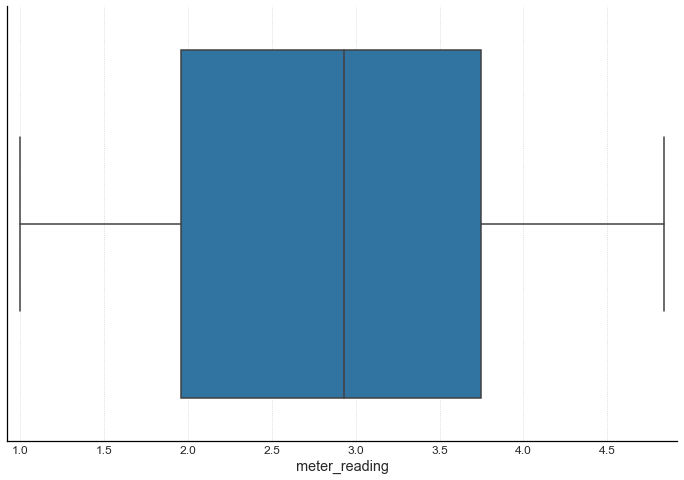

In [6]:
q50 = np.log1p(all_df['meter_reading'].quantile(0.6))
q10 = all_df['meter_reading'].quantile(0.05)

meter_ = all_df['meter_reading'][(all_df['meter_reading'] < q50) & (all_df['meter_reading'] > 1)]
print('New shape:', meter_.shape)
sns.boxplot(meter_)
plt.show()

In [7]:
df = all_df[(all_df['meter_reading'] < q50) & (all_df['meter_reading'] > 1)]


In [8]:
df.shape

(863107, 16)

## Write to CSV

In [9]:
# df.to_csv('../data/clean_data.csv', encoding='utf-8', index=False)

## Time-Series Meter Reading Plot

In [10]:

df = df.set_index('timestamp')

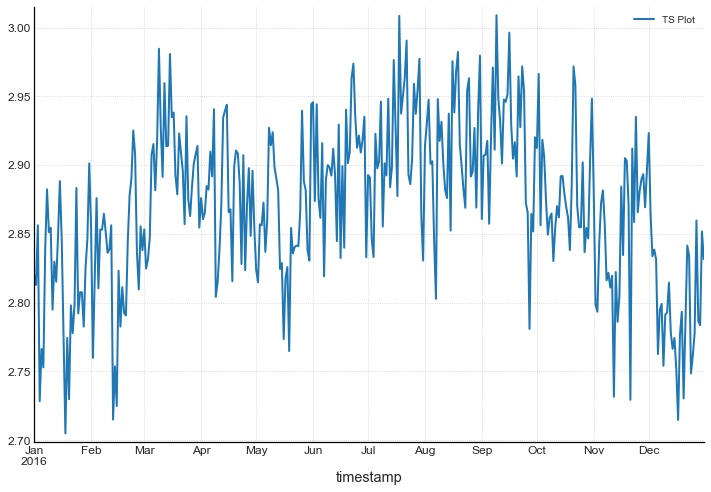

In [11]:
df = df.resample('D').mean()
df['meter_reading'].plot(
    kind='line', 
    label='TS Plot',
    legend=True,
    linewidth=2
)
plt.show()

## Build New DataFrame
Create new DF and make a sample Time-Series plot

In [12]:
# df_new = pd.DataFrame()

In [13]:

# df_new['timestamp'] = np.arange('2017-01', '2017-03', dtype='datetime64[D]')

In [14]:
# df_new.head()

In [15]:
# sample from original DF
df.reset_index(drop=True, inplace=True)
df['meter_reading'].describe()

count   366.0000
mean      2.8712
std       0.0590
min       2.7050
25%       2.8341
50%       2.8739
75%       2.9120
max       3.0090
Name: meter_reading, dtype: float64

In [16]:
# df_new.head()

In [17]:
# df_new = df_new.set_index('timestamp')

In [35]:
def make_sample_df(df, date_range=('2017-01', '2017-03')):
    """
    Create new sample DataFrame with sample meter readings, and new
    timestamp given `date_range`.
    """
    df_new = pd.DataFrame()
    df_new['timestamp'] = np.arange(date_range[0], date_range[1], dtype='datetime64[D]')
    
    # get number of samples 
    n_samples = df_new.shape[0]
    
    # sample from original DF
    df.reset_index(drop=True, inplace=True)
    df_new['meter_reading'] = df['meter_reading'].sample(n_samples).values
    # set new index to `timestamp`
    df_new = df_new.set_index('timestamp')
    
    return df_new

def make_sample_plot(df, date_range=('2017-01', '2017-03'), resample='D'):
    df_new = make_sample_df(df, date_range)
    df_new = df_new.resample(resample).mean()
    df_new['meter_reading'].plot(
        kind='line', 
        label='TS Plot',
        legend=True,
        linewidth=2
    )
    

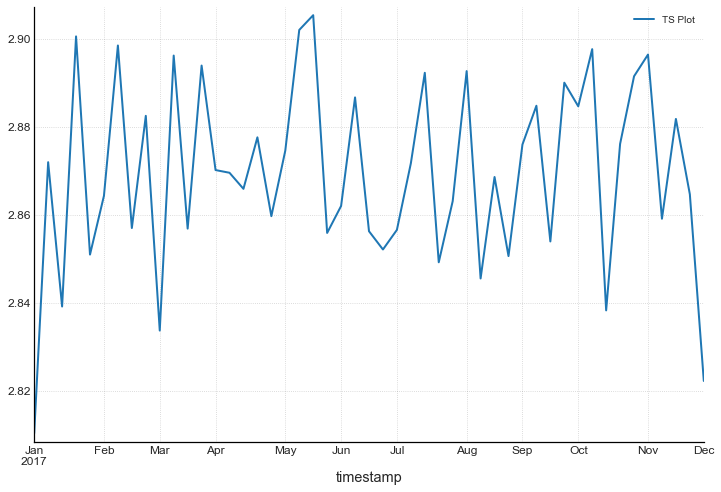

In [36]:
make_sample_plot(df, date_range=('2017-01-01 00:00:00', '2017-12-01 00:00:00'), resample='W')

## Plotly Time-Series Plot

In [37]:
df_new = make_sample_df(df)

In [38]:
# fig = [go.Scatter(x=df_new.index, 
#                   y=df_new['meter_reading'].values,
#                   name='Predictions')
#                 ]
# json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

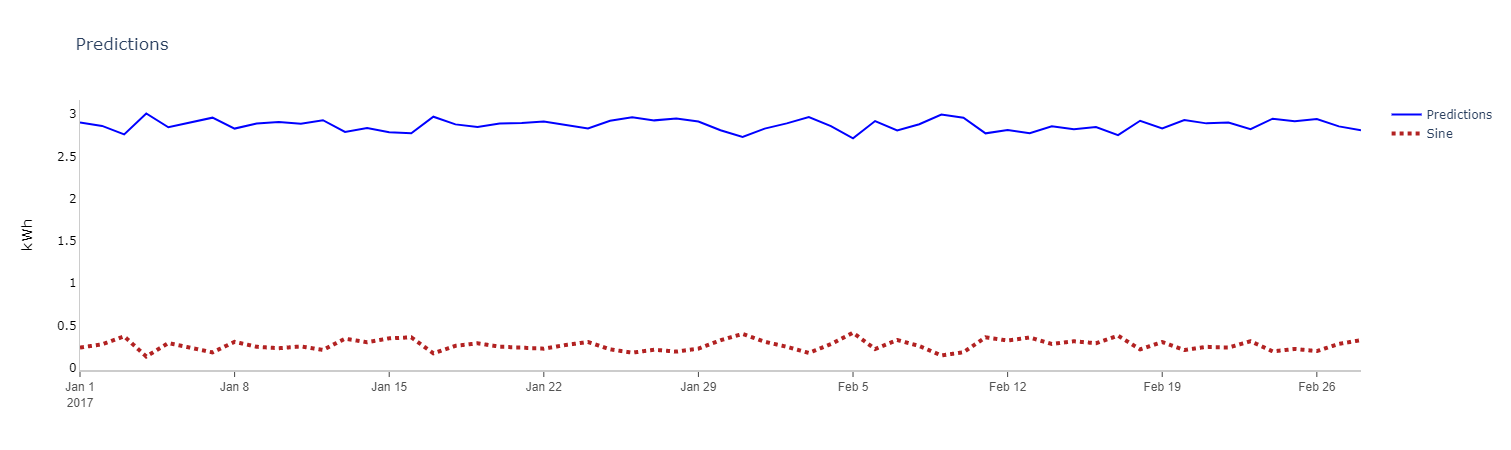

In [39]:
df_new = make_sample_df(df)
y = df_new['meter_reading'].values
y2 = np.sin(df_new['meter_reading'].values)

fig = go.Figure([go.Scatter(x=df_new.index, 
                            y=df_new['meter_reading'].values,
                            name='Predictions',
                            line=dict(color='blue'),)
                ])

fig.add_trace(go.Scatter(x=df_new.index, 
                         y=y2,
                         name='Sine',
                         line=dict(color='firebrick', width=4, dash='dot')))
# Edit the layout
fig.update_layout(title='Predictions',
                  yaxis_title='kWh',
                  plot_bgcolor='white',
                  
                  yaxis=dict(
                      showgrid=True,
                      zeroline=True,
                      showline=True,
                      linecolor='rgb(204, 204, 204)',
                      showticklabels=True,
                      color='black'
                  ),
                  xaxis=dict(
                      showline=True,
                      showgrid=True,
                      showticklabels=True,
                      linecolor='rgb(204, 204, 204)',
                      linewidth=2,
                      ticks='outside',
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)',
                      ),
                  )
                 )
fig.show()

In [40]:
# fig.to_json()
